In [198]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.signal import savgol_filter

# mapping '/' to __truediv__()
from __future__ import division 

from sklearn.metrics import mean_absolute_error
# possible alternative to above:
# tf.metrics.MeanAbsoluteError()

# helper code
from WindowGenerator import WindowGenerator
from Baseline import Baseline

mpl.rcParams['figure.figsize'] = (12, 3)
mpl.rcParams['axes.grid'] = False

VERBOSE = True
MAX_EPOCHS = 30
CONV_WIDTH = 14 # used as input width

if VERBOSE:
    print('Setup Complete')

Setup Complete


In [199]:
df = pd.read_csv('data/ibm_edit.csv')

# seperates date_time from df
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')

# smooth data
df['y'] = savgol_filter(df['y'], 55, 3) # window size, polynomial order

# seemingly doesn't work if data is before 1970
# timestamp_s = date_time.map(datetime.datetime.timestamp)

if VERBOSE:
    print( date_time )

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

if VERBOSE:
    print( "total samples = {0:d}".format( n ) )
    print( "----------------------------------------" )
    print( "train_df samples = {0:d}".format( len( train_df ) ) )
    print( "val_df samples = {0:d}".format( len( val_df ) ) )
    print( "test_df samples = {0:d}".format( len( test_df ) ) )
    print( "----------------------------------------" )
    print( "train + val + test = {0:d}".format( len( train_df ) + len( val_df ) + len( test_df ) ) )

0       1962-01-02
1       1962-01-03
2       1962-01-04
3       1962-01-05
4       1962-01-08
           ...    
14054   2017-11-06
14055   2017-11-07
14056   2017-11-08
14057   2017-11-09
14058   2017-11-10
Name: ds, Length: 14059, dtype: datetime64[ns]
total samples = 14059
----------------------------------------
train_df samples = 9841
val_df samples = 2812
test_df samples = 1406
----------------------------------------
train + val + test = 14059


In [200]:
conv_window = WindowGenerator( train_df=train_df, test_df=test_df, val_df=val_df,
                               input_width=CONV_WIDTH, label_width=1, shift=14, label_columns=['y'])
if VERBOSE:
    print( conv_window )

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [27]
Label column name(s): ['y']


In [201]:
def compile_and_fit(model, window, patience=10):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])
    
    return history

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),])

test mean absolute error = 5.880


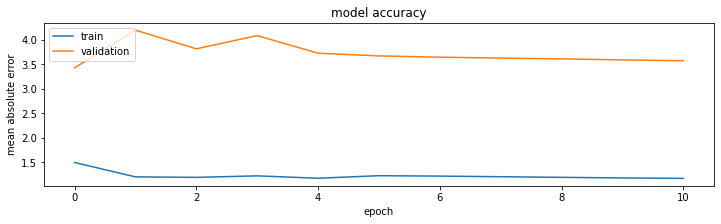

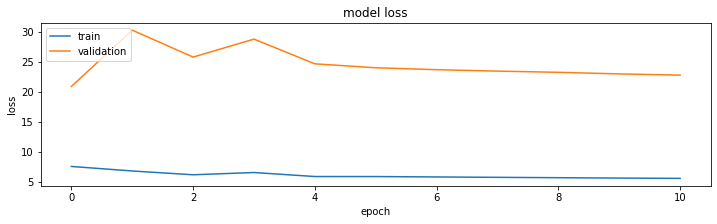

In [202]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()

test_iterator = iter(conv_window.test)

y_p = []
y = []

for inputs, labels in test_iterator:
    
    predictions = conv_model( inputs )
    
    for i in range( predictions.shape[0] ):
        
        y_p.append( predictions[i][0,:][0].numpy() )
        y.append( labels[i][0,:][0] ) 
    
y_p = np.array( y_p )
y = np.array( y )

mae = mean_absolute_error( y_p, y )
print( "test mean absolute error = {0:0.3f}".format( mae ) )

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

test mean absolute error = 5.880


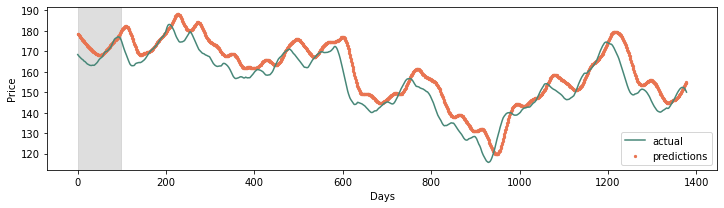

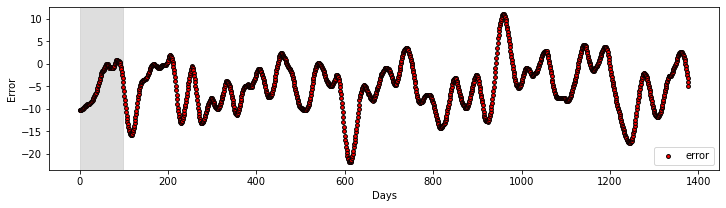

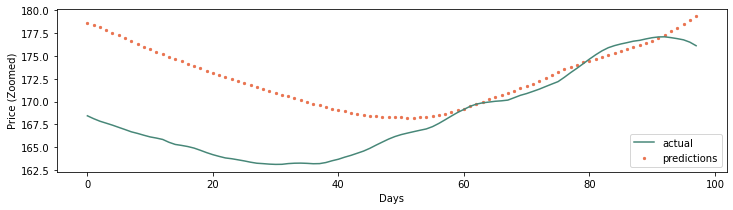

In [203]:
print( "test mean absolute error = {0:0.3f}".format( mae ) )

x = np.arange( 0, len(y), 1 )
zoom_pwr = 14
zoom_idx = int(np.floor(len(y)/zoom_pwr))
x_zoom = np.arange(0, zoom_idx, 1)
y_zoom = y[: zoom_idx]
y_p_zoom = y_p[: zoom_idx]
shd_alpha = 0.6

plt.ylabel('Price')
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
p1, = plt.plot( x, y, label='test', color='#478778' )
p2 = plt.scatter( x, y_p, edgecolors='#E97451', color='#E97451', s=5 )
plt.legend(handles=[p1, p2], labels=['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.ylabel('Error')
p1 = plt.scatter( x, ( y-y_p ), edgecolors='black', color='red', s=15 )
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
plt.legend(handles=[p1], labels=['error'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.ylabel('Price (Zoomed)')
plt.plot( x_zoom, y_zoom, label='test', color='#478778' )
plt.scatter( x_zoom, y_p_zoom, edgecolors='#E97451', color='#E97451', s=5)
plt.legend(['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

## Single window prediction
Load new file with data points representing recent history.
Use model to make a single prediction a given distance into the future.

0
0


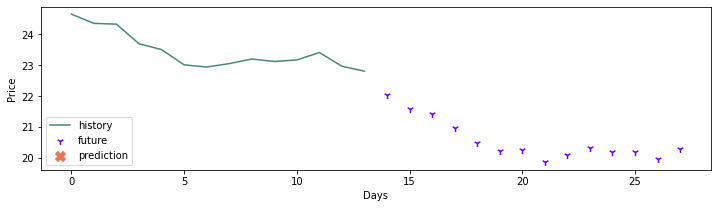

In [248]:
# specify pathname
pathname = 'data/ge_edit.csv'
df = pd.read_csv(pathname)

# seperates date_time from df
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

# divide dataframe
input_df = df[:CONV_WIDTH]
future_df = df[CONV_WIDTH:] # pretend we don't know these future values

# make prediction
y_p = []
conv_window = WindowGenerator(train_df=input_df, test_df=input_df, val_df=input_df,
                              input_width=CONV_WIDTH, label_width=1, shift=14, label_columns=['y'])
print(conv_window.test.cardinality().numpy()) #********************* nothing to iterate over
test_iterator = iter(conv_window.test)
for inputs, labels in test_iterator:
    predictions = conv_model( inputs )
    for i in range( predictions.shape[0] ):
        y_p.append( predictions[i][0,:][0].numpy() )

# history
y = input_df.to_numpy()
x = np.arange(0, len(y), 1)
# future
y_f = future_df.to_numpy()
x_f = np.arange(len(y), len(y) + len(y_f), 1)
# prediction
y_p = np.array( y_p )
if (len(y_p) == 0):
    x_p = []
else:
    x_p = len(y)+len(y_f)-1

print(len(y_p)) #********************* y_p has no value

# plot
plt.ylabel('Price')
plt.plot(x, y, color='#478778')
plt.scatter(x_f, y_f, edgecolors='#6F00FF', color='#6F00FF', s=50, zorder=0, marker='1')
plt.scatter(x_p, y_p, edgecolors='#E97451', color='#E97451', s=100, marker='X')
plt.legend(['history', 'future', 'prediction'], loc='lower left')
plt.xlabel('Days')
plt.show()